In [1]:
!pip install image_classifiers matplotlib
#!pip install keras==3.1.1 tensorflow==2.16.1
import tensorflow as tf
import keras
from keras.applications import ResNet50V2
from keras import Sequential, Input
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.datasets import cifar100
from keras.models import Model
from classification_models.keras import Classifiers
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

2024-05-04 12:14:26.882801: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 12:14:26.884088: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 12:14:26.891164: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 12:14:26.972592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 12:14:28.150621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
batch_size = 100
num_classes = 100
n_images_test = 10000

In [3]:
!mc cp s3/afeldmann/projet_cnam/modele_enseignant.keras /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_enseignant.keras
model_enseignant = Sequential([
    Input((224,224,3)),
    ResNet50V2(include_top=False, weights='imagenet', pooling="avg"),
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))
])
# Keras 3.1.1 est buggé et le chargement direct ne marche pas ici, même si les poids sont bien enregistrés
model_enseignant.load_weights("/home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_enseignant.keras")
model_enseignant.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

...nant.keras: 135.73 MiB / 135.73 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 52.48 MiB/s 2s

In [4]:
def ResNet18():
    resnet18, preprocess_input = Classifiers.get('resnet18')
    resnet = resnet18((224, 224, 3), weights='imagenet', include_top=False)
    resnet_output = GlobalAveragePooling2D()(resnet.output)
    resnet = Model(inputs=resnet.input, outputs=resnet_output)
    return resnet

def new_modele_resnet():
    model = Sequential([
        Input((224,224,3)),
        ResNet18(),
        Dropout(0.25),
        Dense(256, activation="sigmoid", kernel_regularizer = keras.regularizers.L1(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation="softmax", kernel_regularizer = keras.regularizers.L2(0.001))
    ])
    model.compile(metrics=['accuracy'])
    return model

In [5]:
!mc cp s3/afeldmann/projet_cnam/model_etudiant_t1_a0.keras /home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_distille.keras
model_etudiant_distille = new_modele_resnet()
model_etudiant_distille.load_weights("/home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_distille.keras")
model_etudiant_distille.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

...1_a0.keras: 43.54 MiB / 43.54 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 37.62 MiB/s 1s

In [6]:
!mc cp s3/afeldmann/projet_cnam/model_etudiant_t1_a100.keras /home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_temoin.keras
model_etudiant_temoin = new_modele_resnet()
model_etudiant_temoin.load_weights("/home/onyxia/work/projet_distillation_cnam/sauvegardes/model_etudiant_temoin.keras")
model_etudiant_temoin.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

...a100.keras: 43.54 MiB / 43.54 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 50.24 MiB/s 0s

In [7]:
def preprocessing(image, label):
    image = tf.image.resize(image, (224, 224))
    label = tf.squeeze(tf.one_hot(label, depth = num_classes), axis = 0)
    return  image, label, 

def preprocess_resnet(image, label):
    return preprocess_input(image), label, image

def load_cifar_test():
    _, test_dataset = cifar100.load_data()
    test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).map(preprocessing, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size).map(preprocess_resnet, num_parallel_calls = tf.data.AUTOTUNE)
    return test_dataset

In [8]:
@tf.function
def argmax_equals(x,y):
    return tf.equal(tf.argmax(x, axis = 1), tf.argmax(y, axis = 1))

In [9]:
test_dataset = load_cifar_test()

In [10]:
@tf.function
def make_burt(images, label, image_orig):
    enseignant_pred = model_enseignant(images, training = False)
    etudiant_temoin_pred = model_etudiant_temoin(images, training = False)
    etudiant_distille_pred = model_etudiant_distille(images, training = False)
    bons_enseignant = argmax_equals(enseignant_pred,label)
    bons_etudiant_temoin = argmax_equals(etudiant_temoin_pred, label)
    bons_etudiant_distille = argmax_equals(etudiant_distille_pred, label)
    tdc = tf.cast(
        tf.stack([bons_enseignant,
                  tf.math.logical_not(bons_enseignant),
                  bons_etudiant_temoin,
                  tf.math.logical_not(bons_etudiant_temoin),
                  bons_etudiant_distille,
                  tf.math.logical_not(bons_etudiant_distille)],
                  axis=1),
        tf.int32)
    burt = tf.linalg.matmul(tf.transpose(tdc),tdc)
    return burt

burt = test_dataset.map(make_burt, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).reduce(0, lambda x, y: x + y).numpy()

In [11]:
burt

array([[7651,    0, 6309, 1342, 6331, 1320],
       [   0, 2349,  765, 1584,  671, 1678],
       [6309,  765, 7074,    0, 6092,  982],
       [1342, 1584,    0, 2926,  910, 2016],
       [6331,  671, 6092,  910, 7002,    0],
       [1320, 1678,  982, 2016,    0, 2998]], dtype=int32)

In [12]:
burt_lignes = np.apply_along_axis(lambda x: np.round(x/x.sum()*300, 1), 1, burt)
burt_lignes

array([[100. ,   0. ,  82.5,  17.5,  82.7,  17.3],
       [  0. , 100. ,  32.6,  67.4,  28.6,  71.4],
       [ 89.2,  10.8, 100. ,   0. ,  86.1,  13.9],
       [ 45.9,  54.1,   0. , 100. ,  31.1,  68.9],
       [ 90.4,   9.6,  87. ,  13. , 100. ,   0. ],
       [ 44. ,  56. ,  32.8,  67.2,   0. , 100. ]])

In [13]:
np.savetxt("sauvegardes/burt.csv", burt, delimiter = ",")
np.savetxt("sauvegardes/burt_lignes.csv", burt_lignes, delimiter = ",")
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/burt.csv s3/afeldmann/projet_cnam/burt.csv
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/burt_lignes.csv s3/afeldmann/projet_cnam/burt_lignes.csv

...lignes.csv: 900 B / 900 B ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 5.66 KiB/s 0s]11;?\

In [14]:
@tf.function
def get_probas(bons_enseignant, bons_etudiant_temoin, bons_etudiant_distille, preds):
    max_preds = tf.math.reduce_max(preds, axis = 1)
    tdc = tf.cast(
        tf.stack([bons_enseignant,
                  tf.math.logical_not(bons_enseignant),
                  bons_etudiant_temoin,
                  tf.math.logical_not(bons_etudiant_temoin),
                  bons_etudiant_distille,
                  tf.math.logical_not(bons_etudiant_distille)],
                  axis=1),
        tf.float32)
    burt_probas = tf.linalg.matmul(tf.transpose(tdc) * max_preds, tdc)
    return burt_probas

@tf.function
def make_probas(images, label, images_orig):
    enseignant_pred = model_enseignant(images, training = False)
    etudiant_temoin_pred = model_etudiant_temoin(images, training = False)
    etudiant_distille_pred = model_etudiant_distille(images, training = False)
    bons_enseignant = argmax_equals(enseignant_pred,label)
    bons_etudiant_temoin = argmax_equals(etudiant_temoin_pred, label)
    bons_etudiant_distille = argmax_equals(etudiant_distille_pred, label)
    burt_probas_enseignant = get_probas(bons_enseignant, bons_etudiant_temoin, bons_etudiant_distille, enseignant_pred)
    burt_probas_etudiant_temoin_pred = get_probas(bons_enseignant, bons_etudiant_temoin, bons_etudiant_distille, etudiant_temoin_pred)
    burt_probas_etudiant_distille = get_probas(bons_enseignant, bons_etudiant_temoin, bons_etudiant_distille, etudiant_distille_pred)
    return burt_probas_enseignant, burt_probas_etudiant_temoin_pred, burt_probas_etudiant_distille

burt_probas_sum = (
    test_dataset
    .map(make_probas, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    .reduce((tf.constant(0.0,shape=burt.shape),)*3, lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
)

burt_probas = [i.numpy() / burt for i in burt_probas_sum]

2024-05-04 12:17:12.539729: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
/tmp/ipykernel_4624/2490416569.py:36: RuntimeWarning: invalid value encountered in divide
  burt_probas = [i.numpy() / burt for i in burt_probas_sum]


In [15]:
burt_probas_en_forme = [[f"{burt_probas[0][i, j]*100:.0f} | {burt_probas[1][i, j]*100:.0f} | {burt_probas[2][i, j]*100:.0f}" for j in range(burt_probas[0].shape[1])] for i in range(burt_probas[0].shape[0])]
np.savetxt("sauvegardes/burt_probas.csv", burt_probas_en_forme, fmt = "%s", delimiter = ";")
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/burt_probas.csv s3/afeldmann/projet_cnam/burt_probas.csv

...probas.csv: 474 B / 474 B ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 4.62 KiB/s 0s

In [16]:
burt_probas

[array([[0.88465286,        nan, 0.91609836, 0.73682118, 0.91825242,
         0.72350274],
        [       nan, 0.56961479, 0.57969624, 0.56474597, 0.57058134,
         0.56922827],
        [0.91609836, 0.57969624, 0.87971888,        nan, 0.90770651,
         0.7060936 ],
        [0.73682118, 0.56474597,        nan, 0.6436677 , 0.73249123,
         0.60357375],
        [0.91825242, 0.57058134, 0.90770651, 0.73249123, 0.88493487,
                nan],
        [0.72350274, 0.56922827, 0.7060936 , 0.60357375,        nan,
         0.63715438]]),
 array([[0.27112332,        nan, 0.3077712 , 0.0988345 , 0.30312394,
         0.11764131],
        [       nan, 0.11674783, 0.14347634, 0.1038392 , 0.13914549,
         0.10779145],
        [0.3077712 , 0.14347634, 0.29000389,        nan, 0.31567543,
         0.13074661],
        [0.0988345 , 0.1038392 ,        nan, 0.10154379, 0.09818653,
         0.10305928],
        [0.30312394, 0.13914549, 0.31567543, 0.09818653, 0.28740988,
                nan

In [17]:
coarse_label = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver',
    'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly',
    'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach',
    'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
    'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard',
    'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum',
    'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman','worm'
]

In [18]:
images_bizarres = (
    test_dataset
    .map(lambda images, labels, images_orig: (images,
                                              tf.argmax(labels, axis = 1),
                                              images_orig,
                                              tf.argmax(model_enseignant(images, training = False), axis = 1),
                                              tf.argmax(model_etudiant_distille(images, training = False), axis = 1)))
    .map(lambda images, labels, images_orig, enspred, etupred: (images, labels, images_orig, enspred, etupred,
                                                                tf.squeeze(tf.math.logical_and(tf.equal(labels, etupred),tf.math.logical_not(tf.equal(labels, enspred))))))
    .unbatch()
    .filter(lambda images, labels, images_orig, enspred, etupred, cond: cond)
    .map(lambda images, labels, images_orig, enspred, etupred, cond: (images_orig, enspred, etupred))
    .prefetch(tf.data.AUTOTUNE)
)

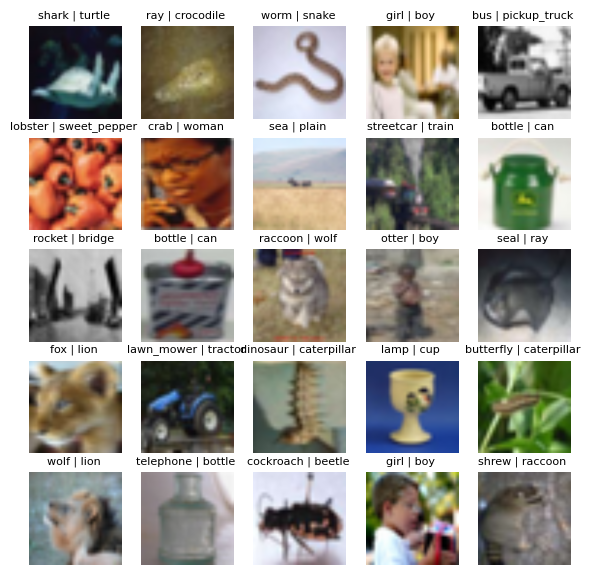

In [19]:
images_bizarres_iter = iter(images_bizarres)

plt.figure(figsize=(7, 7))
for i in range(25):
    img, enspred, etupred = next(images_bizarres_iter)
    img = img.numpy()
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img/255.0, cmap='gray')
    ax.title.set_text(f"{coarse_label[int(enspred.numpy())]} | {coarse_label[int(etupred.numpy())]} ")
    ax.title.set_fontsize(8)
    plt.axis('off')
plt.show()